In [1]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import poppy
import skimage
from skimage.registration import phase_cross_correlation
import copy
from importlib import reload
import matplotlib.pyplot as plt


import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

wavelength = 633e-9
fl = 450e-3
fsm_pupil_diam = 7.1e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(1/pxscl_lamD)

v_bias = np.array([[50,50,50]]).T

pxscl_lamD * as_per_lamD

18.389524275269295 arcsec
11.62890385793019


/opt/conda/envs/km310gpu/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


<Quantity 1.58136351 arcsec>

In [2]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [19]:
npsf = 100
cam.set_roi(570, 900, npsf, client0)

In [20]:
cam.set_exptime(0.0001, client0)

INFO:utils:Got semaphore index 3.


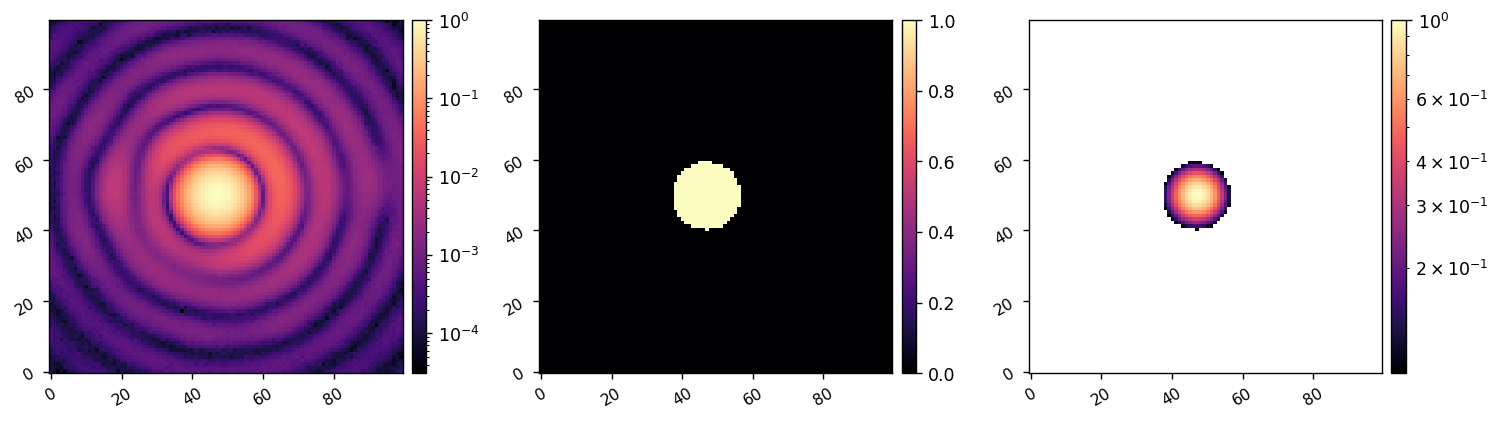

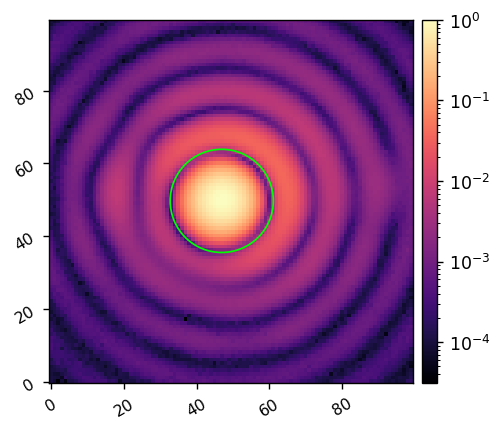

In [3]:
cam.Nframes = 1000
im_bias = cam.snap()

reload(utils)
cen = utils.centroid(im_bias, thresh=0.1, plot=True)
imshow1(im_bias, lognorm=True, patches=[Circle(cen, 1.22/pxscl_lamD, fill=False, color='lime')])


In [16]:
freq = 1/2 * Nsamps
try:
    print('Modulating FSM ...')
    i = 0
    while i<Nsamps+1:
        if i==Nsamps:
            i = 0
        fsm.write(volt_commands[i])
        time.sleep(1/freq)
        i += 1
except KeyboardInterrupt:
    print('FSM modulation stopped!')
    fsm.write(v_bias)
    time.sleep(0.25)

Modulating FSM ...
FSM modulation stopped!


In [21]:
t_total = 10*u.s
exp_time = client0[f'campupil.exptime.current']
fps = client0[f'campupil.fps.current']
data = {
    'EXPTIME':exp_time,
    'FPS':fps, 
    'T_TOTAL':t_total.to_value(u.s),
}

In [8]:
cam.Nframes = t_total.to_value(u.s)*fps
print(cam.Nframes)

frames = cam.snap_cube()


12453.2995605469


In [20]:
frames.shape

(12454, 100, 100)

In [23]:
data.update({'IMAGES':frames})
utils.save_pickle(f'data/sin-mod/{today}_sin_mod_res_req.pkl', data)

Saved data to:  data/sin-mod/20241206_sin_mod_res_req.pkl


# Analyze data

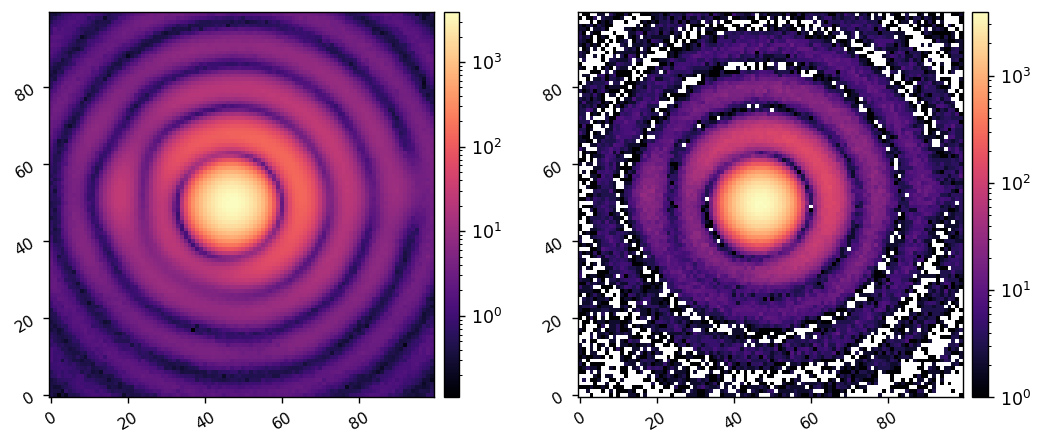

In [26]:
data = utils.load_pickle(f'data/sin-mod/{today}_sin_mod_res_req.pkl')
ims = data['IMAGES']

N = ims.shape[0]
fps = data['FPS']
mean_frame = np.mean(ims, axis=0)
imshow2(mean_frame, ims[0], lognorm=True)

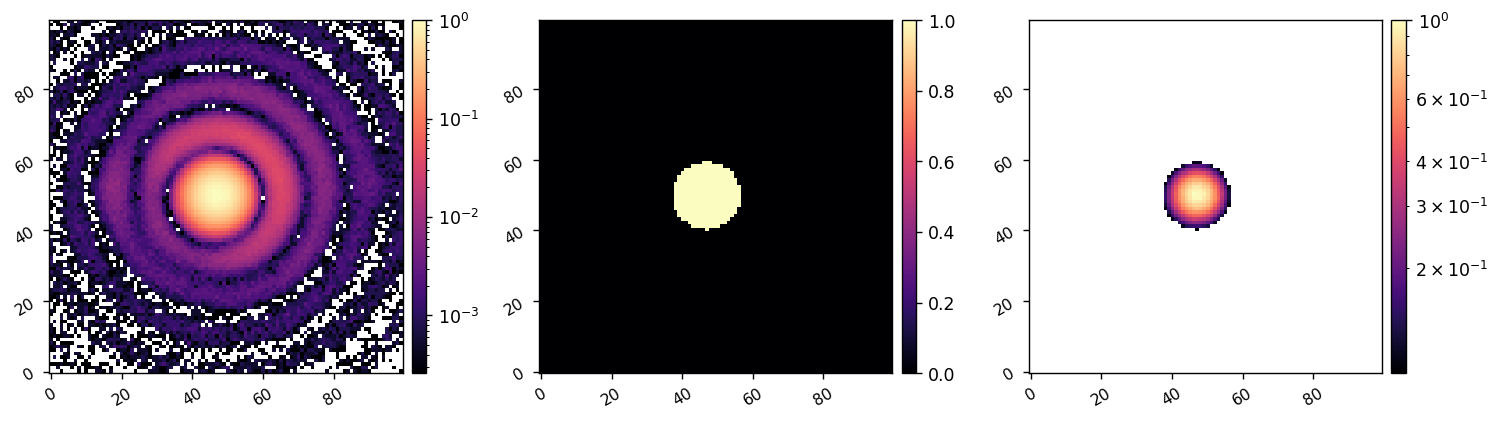

In [30]:
thresh = 0.1

shift_pix = []
cen_0 = utils.centroid(ims[0].astype(float), thresh=thresh, plot=True)
for i in range(N):
    cen = utils.centroid(ims[i].astype(float), thresh=thresh, plot=0)
    shift = cen - cen_0
    shift_pix.append(shift)
shift_pix = np.array(shift_pix)

shift_pix[:,0] = shift_pix[:,0] - np.mean(shift_pix[:,0])
shift_pix[:,1] = shift_pix[:,1] - np.mean(shift_pix[:,1])

0.060645056681537135 0.04276671898321689


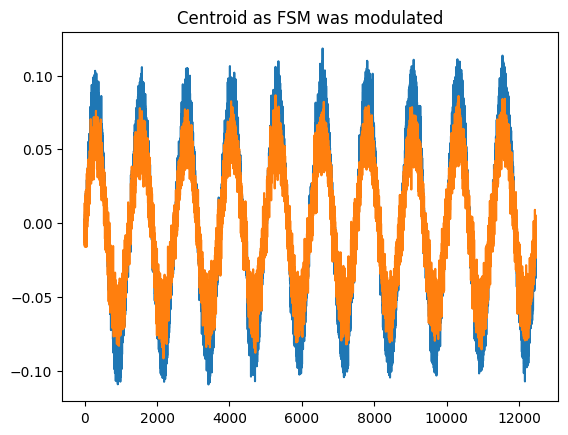

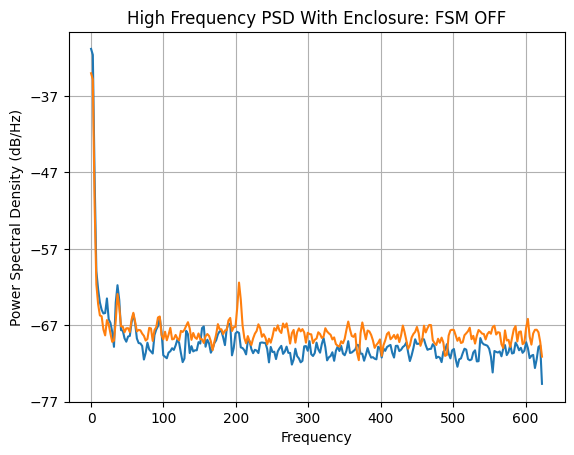

In [32]:
print(np.sqrt(np.mean(np.square(shift_pix[:, 0]))), np.sqrt(np.mean(np.square(shift_pix[:, 1]))))

plt.plot(shift_pix[:,0])
plt.plot(shift_pix[:,1])
plt.title('Centroid as FSM was modulated')
plt.show()

py, freq = plt.psd(shift_pix[:,0], Fs=fps, NFFT=512)
px, freq = plt.psd(shift_pix[:,1], Fs=fps, NFFT=512)
plt.title('High Frequency PSD With Enclosure: FSM OFF')
# plt.ylim([-50, -30])
# plt.yticks([-50, -30])
plt.show()